# Qiskit patterns on mirror kicked Ising experiments

**Authors: Joana Fraxanet and Nick Bronn**\
IBM Quantum Algorithm Engineering team

Addressing timely problems with quantum computers requires not only proficient hardware and software capabilities, but also efficient and scalable frameworks, which allow to reuse and simplify code, as well as maximize compatibility with existing software and hardware ecosystems. In this one day workshop we will introduce a workflow based on Qiskit patterns, which consists of a four-step process for running algorithms on a quantum computer. The steps include the mapping of significant problems onto quantum computers, which involves integrating both the advantages and limitations of current technology into the problem definition phase, the optimization of the workload to the hardware, where the circuits are transformed to match the constraints and instructions of the hardware, and the execution of the circuits in a runtime, including the implementation of efficient error mitigation techniques. We will cover each of these steps and provide a practical example using Qiskit code.

In this tutorial, you will explore the Qiskit pattern framework by building a mirror kicked Ising experiment. The outline of the workflow will be the following:

1. [Map problem to quantum circuits and operators](#1-map-problem-to-quantum-circuits-and-operators)
2. [Optimize for target hardware](#2-optimize-for-target-hardware) 
3. [Execute on target hardware](#3-execute-on-target-hardware)
4. [Post-processing results](#4-post-processing-results)


## Requirements

Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later with visualization support
- Qiskit Runtime 0.22 or later 

> See [this link](https://docs.quantum.ibm.com/guides/install-qiskit) for installation support.


## 1. Map problem to quantum circuits and operators


In this tutorial, we are interested in simulating the dynamics of a spin chain as pictured by the one-dimensional _transverse-field Ising model_ (TFIM) with open boundary conditions.\
The physics of this problem in a heavy-hex lattice were studied in the [recent utility work](https://doi.org/10.1038/s41586-023-06096-3) by Kim et al.

Let's start by building the trotterized circuit to implement the dynamics for a one-dimensional model.

### Exercise 1: Building the circuit

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def TFIMCircuit(num_qubits, trotter_steps):

    qc = QuantumCircuit(num_qubits)

    beta = Parameter("β")
    gamma = Parameter("γ")
    
    for step in range(trotter_steps):
        
        # Add your code here

    return qc

In [ ]:

# Add your code here

print('Depth of two-qubit gates: ', reference_circuit.depth(lambda x: len(x.qubits) == 2))
reference_circuit.draw("mpl", style="bw")


### Exercise 2: Mirror circuits: the compute-uncompute pattern

The problem with the previous circuit as it stands is that its final solution is in principle unknown. Therefore, we do not have an understanding of whether the results that we get out of the quantum computer are good or not. 

A number of tentative approaches to validate quantum circuits exist. An example of this is Cliffordization, which is used in the [utility work](https://doi.org/10.1038/s41586-023-06096-3) by Kim et al. 

For the purposes of this work, we will use another benchmarking technique: _mirror_ circuits. Mirror circuits are composed by a first stage where the original circuit $\hat{U}$ is applied, and a second one where it is reversed $\hat{U}^\dagger$; following a _compute-uncompute_ pattern. For execution, we also need to bind the circuit parameters to specific values.

In [ ]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

def compute_uncompute(circuit, barrier=True, inplace=False):

    # Add your code here 

    return circuit

# Construct mirror circuit
mirror_reference_circuit = compute_uncompute(reference_circuit)
# Assign the parameters to the circuit following the utility paper example
mirror_circuit = mirror_reference_circuit.assign_parameters([np.pi/4, -np.pi/2]) #non-clifford point

print('Depth of two-qubit gates: ', mirror_circuit.depth(lambda x: len(x.qubits) == 2))
mirror_circuit.draw("mpl", style="bw")

> **NOTE:** Qiskit requires a *barrier* to be placed between the compute and uncompute parts of the circuit to avoid simplification over transpilation later on. Moreover, the depth of the circuits is doubled by the *compute-uncompute* construct.

### Exercise 3: Choosing an observable

The ideal outcome of such circuits will trivially be the input state $|0\rangle^{\otimes N}$, with expectation value one for any Pauli observable. These circuits will nonetheless pick up noise during the execution, which will distance their results from the ideal solution in ways that should be similar to those in the original circuit for twice the one-qubit and two-qubit depth. For this tutorial, we choose to measure the Pauli observable $Z$ on each qubit, with coefficient $1.0$. Since we require the expectation value of all the observables separately, we create an array containing each of these observables. Later, we can compute the mean of these values classically.

> **NOTE:** Since all the observables commute, Qiskit Runtime will handle all of them in a single execution, therefore not increasing the execution time on the QPU.

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# Add your code here

print(observables)

### Bonus exercise: 

You can also try to simulating the dynamics of a spin chain for the two dimensional _transverse-field Ising model_ (TFIM) in the heavy hex lattice, matching the device connectivity, to reproduce the results in the [recent utility work](https://doi.org/10.1038/s41586-023-06096-3) by Kim et al.
In this case, you need to build three layers of $ZZ$ gates connecting all nearest neighbor qubits in the heavy-hex topology. The layers need to be built by hand, looking at the connectivity map, which can be obtained from the backend using ```cm = backend.target.build_coupling_map()```.

In [ ]:
def TFIMCircuit_heavyhex(num_qubits, trotter_steps):

    qc = QuantumCircuit(num_qubits)

    beta = Parameter("β")
    gamma = Parameter("γ")
    
    for step in range(trotter_steps):
        
        layer_0 = # Add your code here
        layer_1 = # Add your code here
        layer_2 = # Add your code here
        
        # Add your code here

    return qc
    

> **NOTE:** This circuit is built so that it directly maps to the hardware connectivity. For the following section we will consider the 1D simulation, but note that for the heavy hex simulation one would need to account for this in the transpilation step. In particular, one would need to specify the ```initial_layout```, which in this case are just the $127$ qubits in order, and set the ```layout_method``` to trivial in order to avoid any optimization on top. Therefore, you would need: ```pass_manager = generate_preset_pass_manager(backend=backend,initial_layout=range(127), layout_method="trivial", optimization_level=1)```.

## 2. Optimize for target hardware

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)
print(backend)

### Choose layout with reference circuit

In [ ]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)
init_layout = isa_circuit.layout.final_index_layout()
print(f"Chosen layout: {init_layout}")
isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)


In [ ]:
# Let's visualize this on the HW
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

In [ ]:
isa_observables = [observable.apply_layout(isa_circuit.layout) for observable in observables] #to match the layout of the isa_circuit
print(isa_observables)

### Construct Evolutions at Different Times

Each Trotter step consists of a small time evolution, with entanglement building in the circuit the further in time we evolve. If we want to observe the evolution of the state as a function of time, we need a list of quantum circuits, one for each time (since the observables collapse the quantum information).

In [ ]:
num_trotter_steps = 15

ising_circuits = []
for num_trot in range(1, num_trotter_steps+1):
    reference_circuit = TFIMCircuit(num_qubits=num_qubits, trotter_steps=num_trot)
    # Assign the parameters to the circuit following the utility paper example
    assigned_circuit = reference_circuit.assign_parameters([np.pi/4,-np.pi/2]) #non-clifford point
    # Add a barrier to prevent circuit optimization of mirrored operators
    assigned_circuit.barrier()
    # Construct mirror circuit
    ising_circuits.append(compute_uncompute(assigned_circuit, assigned_circuit))

In [ ]:
ising_circuits[0].draw(fold=-1)

### Applying layout too all circuits saves classical overhead

Going through all transpilation steps on all Trotter steps took 76 seconds on M1 laptop. Better to apply initial layout to all circuits by putting it in the preset passmanager.

In [ ]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234, initial_layout=init_layout,
)
ising_isa_circuits = pass_manager.run(ising_circuits)

saves classical overhead in routing/layout (14 sec).



In [ ]:
ising_isa_circuits[-1].draw(idle_wires=False, fold=-1)

## 3. Execute on target hardware

You are now ready to run your circuit using the Estimator primitive!

Here you will submit five separate jobs, starting with no error suppression or mitigation, and successively enabling various error suppression and mitigation options available in Qiskit Runtime. 

When using the Estimator primitive, we can use the ```EstimatorOptions()``` object to set the options for error mitigation and error suppression techniques. This table shows the most used ones:

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

For information about the options, refer to the following pages:
- [Estimator options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions)
- [Dynamical decoupling options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions)
- [Pauli Twirling options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions)
- [Resilience options, including Twirled Readour Error eXtinction and Zero Noise Extrapolation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2 )
- [Probabilistic Error Amplification](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.LayerNoiseLearningOptions)

Because these jobs can run independently of each other, you can use batch mode to allow Qiskit Runtime to optimize the timing of their execution.

### Exercise 1: Checking the results for one trotter step and 50 qubits

In [ ]:
from qiskit_ibm_runtime import Batch, EstimatorV2, EstimatorOptions

pub = (isa_circuit, isa_observables)

jobs = []

with Batch(backend=backend) as batch:

    # Set basic EstimatorOptions properties
    options = EstimatorOptions(default_shots=10_000, optimization_level=0, resilience_level=0)

    # Run job0 with no error mitigation

    # Add dynamical decoupling (DD) and run job1

    # Add readout error mitigation (DD + TREX) and run job2

    # Add gate twirling (DD + TREX + PT) and run job3

    # Add zero-noise extrapolation (DD + TREX + PT + ZNE) and run job4

    # Add zero-noise extrapolation with PEA (DD + TREX + PT + ZNE(PEA)) and run job5

We can use the following code to obtain the session ID and the status of our job.

In [ ]:
# Check status
session_id = batch.session_id
print(f"Session ID: {session_id}")
print(f"Status: {batch.status()}")

You can check at the execution time of your job by looking at the usage in ```job.metrics()``` and check the backend it was run on by looking at ```job.backend()```.

## 4. Post-processing results

Finally, we can analyze the data. Here you will retrieve the job results, extract the measured expectation values from them, compute the mean and plot the values, including error bars of one standard deviation.

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the job results
jobs = service.jobs(session_id=session_id)[::-1] # Reverse order to match the order of the jobs
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([np.mean(np.array(pub_result.data.evs)) for pub_result in pub_results])
standard_errors = np.array([np.mean(np.array(pub_result.data.stds)) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE", "+ PEA"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")
ax.set_ylim(0.7, 1.01)

plt.show()

### Exercise 2: Try increasing the number of qubits a bit further (100 qubits or so).

When doing that, you might note the following:
- The results without error mitigation are worse. Running the larger circuit involves executing more gates, so there are more opportunities for errors to accumulate.
- The addition of dynamical decoupling might have worsened performance. This is not surprising, because the circuit is very dense. Dynamical decoupling is primarily useful when there are large gaps in the circuit during which qubits sit idle without gates being applied to them. When these gaps are not present, dynamical decoupling is not effective, and can actually worsen performance due to errors in the dynamical decoupling pulses themselves. 

### Exercise 3: Checking the results per qubit

We can also plot the result of measuring each observable separately. This will allow us to see the differences between different qubits in the actual device. For this, we need to retrieve the layout used for the ```isa_circuit```, which can be done from the job input. By changing the ```index_results```, you can check how the fidelity improves as we implement different EM techniques. 

In [ ]:
from qiskit.visualization import plot_gate_map
import matplotlib as mpl

index_results = 0 #Try different indices to check different EM techniques!

isa_circuit = jobs[index_results].inputs['pubs'][0][0] #Retrieve the isa circuit from the job to get the layout!
result = jobs[index_results].result()[0]

qubit_expval_map = {}
for qubit in range(backend.num_qubits):
    if qubit not in isa_circuit.layout.final_index_layout():
        qubit_expval_map[qubit] = float(-1)
    else:
        qubit_expval_map[qubit] = result.data.evs[isa_circuit.layout.final_index_layout().index(qubit)]

cmap = plt.get_cmap('plasma_r')

qubit_color = []
for exp_val in qubit_expval_map.values():
    if exp_val == -1:
        qubit_color.append('#F5F5F5')
    else:
        color_html = mpl.colors.rgb2hex(cmap(exp_val))
        qubit_color.append(color_html)
        
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))


You can check whether the qubits with smallest expectation values correspond to qubits with large readout errors by looking at the backend information in the [IBM Quantum Platform](https://quantum.ibm.com/). You can also try to plot this results for the simulation on a 100 qubits!

### Bonus: Increasing the depth of the circuit

We would also like to see what happens when we increase the number of trotter steps (circuit depth) and keep the number of qubits constant (50 qubits).

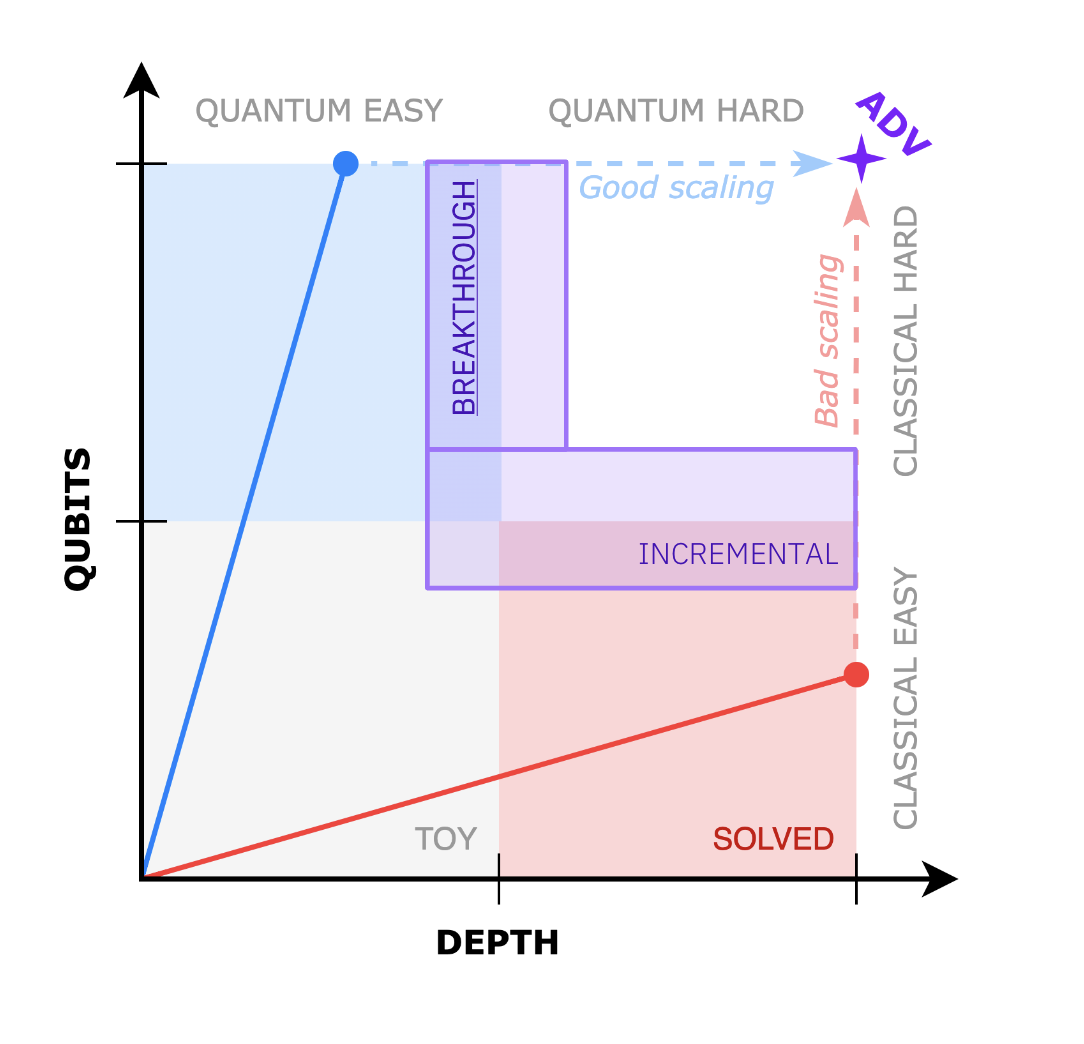

For this, you can use the ```ising_isa_circuits``` list created in the Step 2 (Optimize for target hardware). You only need to create a ```pub``` object for each ```isa_circuit```in the list (the observable is the one defined above). Then, you can execute the jobs as before and retrieve the results. On ```ibm_brisbane``` we obtain the following results for up to 3 trotter steps:

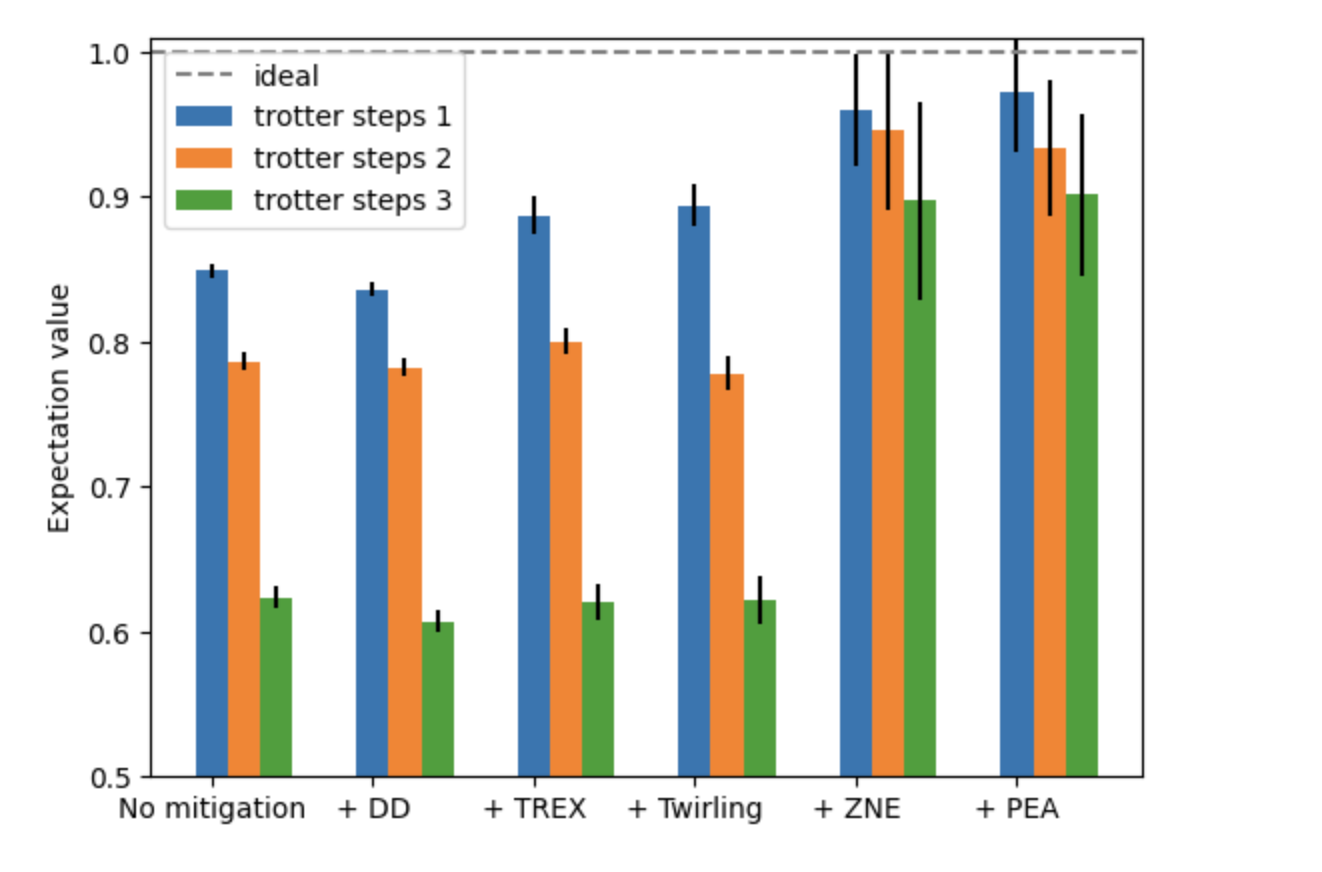